<a href="https://colab.research.google.com/github/JackieVeatch/GCC_2025_PythonWorkshop/blob/main/GCC_1DModelWorkbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Welcome to the 1D Model breakout group!
Jacquelyn Veatch, November 8th 2025 <br> <br>
In this notebook, we will create a compact “zero-dimensional” (global-mean) snow–albedo feedback model with a simple ice-edge proxy. This code will build upon what we learned in "GCC_PythonReview.ipynb", and then explore more data visualization and statistical methods in common Python packages! <br> <br>

The notebook is adapted from Cristina Schultz, who teaches a bunch of cool courses at Northeastern University on Earth systems models. Thanks, Cristina!! https://coe.northeastern.edu/people/schultz-cristina/

In [ ]:
# it is considered best practice to include all imports at the top of your code
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

First, let's define a few variables that will be incorporated into our simple model. For this example, we will use these data as our "obesrvations" or guide points.

In [ ]:
Tmean = [265,255,245,235,225,215] # global-mean temperature (K)
ice_lat = [75,60,45,30,15,0] # latitude of ice edge (deg N)
albedo = [0.15,0.25,0.35,0.45,0.55,0.65] # planetary albedo

These paired lists define how albedo and the ice edge might vary with global temperature. Cooler temperatures go with a lower ice edge latitude (ice closer to the equator) and higher albedo. <br>

Next, we define two linear "closures" (diagnostic relations) <br>
ice_lat = m1 x Tmean +b1 <br>
albedo = m2 x Tmean +b2 <br>

In [ ]:
m1,b1,r1,p1,sd1 = stats.linregress(Tmean,ice_lat)
m2,b2,r2,p2,sd2 = stats.linregress(Tmean,albedo)

These let the model update ice edge and albedo from temperature during the iterations. <br>

Now, we are ready for the basic physcial/experiment settings

In [ ]:
Lrange = [1200, 1600]     # solar constant “experiment” range (W/m^2) for the sweep
epsilon = 1               # emissivity (here kept as 1)
sigma = 5.67E-8           # Stefan–Boltzmann constant (W/m^2 K^4)
Niter = 100               # iterations per L step to relax to equilibrium

In the next two cells, we’ll sweep the incoming sunlight `L` down (“cooling” path) and then up (“warming” path). <br>

The model is a simple energy balance: absorbed shortwave = emitted longwave at equilibrium. <br>

Note: below, we use a conditional statement, `while`, as well as a `for` loop. If you would like a refresher on these programming concepts, check out this notebook: https://github.com/JackieVeatch/GCC_2025_PythonWorkshop/blob/main/Workbook2_LoopsAndConditionals.ipynb

In [ ]:
# === COOLING LOOP ===
# This block simulates the planet cooling as the solar constant (L) decreases.
# It tracks how global temperature (T) and ice-edge latitude (ice_lat) evolve
# as sunlight weakens — showing the onset of a "snowball" Earth state.

albedo = 0.15        # Start with a bright, snowy planet (high reflectivity)
L = Lrange[1]        # Begin from the upper end of the solar constant range (e.g., 1600 W/m²)

# Empty lists to store results for each step of L
Lcool = []            # solar constant values
Tcool = []            # corresponding equilibrium temperatures
ilatcool = []         # corresponding ice-edge latitudes

# Keep looping until the solar constant drops below the lower limit (Lrange[0])
while L > Lrange[0] - 1:

    # Inner loop: iterate several times (Niter) to let temperature, albedo,
    # and ice extent reach equilibrium at the current L.
    for i in range(0, Niter):

        # Step 1: Compute the global mean temperature from the energy balance:
        #   Incoming solar energy * (1 - albedo) / 4 = Outgoing longwave = σ T⁴
        # Rearranged to solve for T:
        T = L * (1 - albedo) / (4 * sigma)
        T = pow(T, 0.25)   # Equivalent to T = (L*(1-α)/(4σ))^(1/4)

        # Step 2: Update albedo based on temperature using the regression fit
        albedo = T * m2 + b2

        # Step 3: Keep albedo within physical limits (can’t go darker than 0.15 or brighter than 0.65)
        albedo = min(albedo, 0.65)
        albedo = max(albedo, 0.15)

        # Step 4: Update the ice-edge latitude from the regression fit
        ice_lat = T * m1 + b1

        # Step 5: Clamp latitude between 0° (equator) and 90° (pole)
        ice_lat = min(ice_lat, 90)
        ice_lat = max(ice_lat, 0)

    # After Niter iterations, store the “equilibrium” state for this solar constant
    Lcool.append(L)
    Tcool.append(T)
    ilatcool.append(ice_lat)

    # Step 6: Decrease the solar constant (simulate gradual cooling of the planet)
    L = L - 10


In [ ]:
# === WARMING LOOP ===
# This block simulates the reverse experiment — gradually increasing
# the solar constant (L) to see how the planet warms and how ice retreats.
# Because of hysteresis, the transition back to an ice-free state
# may not follow the same path as the cooling phase.

albedo = 0.65        # Start with a dim, icy planet (high albedo = snowball Earth)
L = Lrange[0]        # Begin from the lower end of the solar constant range (e.g., 1200 W/m²)

# Empty lists to store results for each step of L
Lwarm = []            # solar constant values (increasing)
Twarm = []            # equilibrium temperatures
ilatwarm = []         # ice-edge latitudes

# Keep looping until the solar constant rises above the upper limit (Lrange[1])
while L < Lrange[1] + 1:

    # Inner loop: iterate several times (Niter) to reach equilibrium
    # between temperature, albedo, and ice extent at each solar constant.
    for i in range(0, Niter):

        # Step 1: Compute equilibrium temperature from the global energy balance
        T = L * (1 - albedo) / (4 * sigma)
        T = pow(T, 0.25)   # Equivalent to T = (L*(1-α)/(4σ))^(1/4)

        # Step 2: Update albedo based on temperature using regression fit
        albedo = T * m2 + b2

        # Step 3: Constrain albedo to remain between 0.15 (dark) and 0.65 (bright)
        albedo = min(albedo, 0.65)
        albedo = max(albedo, 0.15)

        # Step 4: Update ice-edge latitude using regression fit
        ice_lat = T * m1 + b1

        # Step 5: Constrain latitude between 0° (equator) and 90° (pole)
        ice_lat = min(ice_lat, 90)
        ice_lat = max(ice_lat, 0)

    # After Niter iterations, record the equilibrium values for this level of L
    Lwarm.append(L)
    Twarm.append(T)
    ilatwarm.append(ice_lat)

    # Step 6: Increase the solar constant (simulate gradual planetary warming)
    L = L + 10


Intuition: once ice expands, albedo increases, which further cools the planet (positive feedback). As you walk L downward, you can “fall into” a snowball state. <br>

Now lets visualize our results! <br>
First figure: Solar constant vs. equilibrium temperature for the cooling and warming paths.

In [ ]:
plt.plot(Lcool,Tcool,label='Cooling'); plt.plot(Lwarm,Twarm,label='Warming')
plt.xlabel('L',fontsize=14); plt.ylabel('Temperature (K)',fontsize=14)
plt.title('Temperature vs. Solar Constant',fontsize=14); plt.legend(fontsize=12)

Second Figure: Solar constant vs. ice-edge latitude—shows how far equatorward ice can reach on each path.

In [ ]:
plt.plot(Lcool,ilatcool,label='Cooling'); plt.plot(Lwarm,ilatwarm,label='Warming')
plt.xlabel('L',fontsize=14); plt.ylabel('Latitude',fontsize=14)
plt.title('Ice-edge Latitude vs. Solar Constant',fontsize=14); plt.legend(fontsize=12)

### Try it on your own
(1) Change `Niter` to 1, 5, 20, 100. How many iterations do you need for curves to stop changing? <br> <br>
(2) Step size sensitivity test: Double the L step (e.g., `L = L ± 20` instead of ±10). How does step size affect the shape/smoothness of the curves and the apparent hysteresis gap?  <br> <br>
(3) Compare closures: replace `albedo(T)` fit with (a) a piecewise linear relation (flat at low/high T, sloped in the middle), and (b) a sigmoid (e.g., logistic) mapping of T to albedo. Which mapping produces sharper/more realistic transitions? Try using `np.where()` for the piecewise case and `1/(1+np.exp())` for the sigmoid. Consider which one gives a gradual vs. sudden ice retreat as T rises. <br> <br>
(4) Albedo limits: Change the clamps to [0.2, 0.6] and then [0.1, 0.7]. Explain physically why the hysteresis gap widens/narrows. Hint: The range of possible reflectivity controls how strong the snow–albedo feedback can be. A wider albedo range enhances feedback strength. What does that do to stability? <br> <br>
(5) Challenge: Introduce an effective greenhouse factor epsilon < 1 so that outgoing LW = epsilon sigma T^4. Re-derive the temperature. Sweep epsilon from 1.0 to 0.6. How does stronger greenhouse (smaller epsilon) change the hysteresis and snowball threshold? Hint: Replace σ with εσ in the temperature equation: 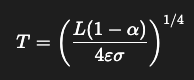